### Writting log:
#### Initially written on Feb 10, 2023
#### Edited on Feb 13, 2023: run the prediction model using narrow-down RNASeq data by consider the genes with expression value (log(RPKM)) greater than 0 in at least 50% 
#### Edited on Feb 14, 2023: compared different feature sets, and plot figures. 

In [357]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [377]:
def model_run(train_data,test_data, train_labels, test_labels):
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], max_depth=para['max_depth'], n_estimators=para['n_estimators'])
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions = clf.predict(test_data)
    
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))

    # Evaluate the accuracy of the XGBoost model
    accuracy = accuracy_score(test_labels, predictions)

    #print("# Accuracy:  the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true")
    #print("Accuracy: ", accuracy)

    cm = confusion_matrix(  list(test_labels), predictions)
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1])
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    #print("Recall: " + str(recall))
    #print("# Recall: TP / (TP + FN)")

    #print("confusion_matrix")
    #print(cm)

    #print("sensitivity: "+ str(sensitivity))

    #print("Precision: " + str(precision))
    #print("# Precision = TP / (TP + FP) ")
    f1 = f1_score(list(test_labels), predictions)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy
    result_summary['Precision'] = precision
    result_summary['sensitivity'] = sensitivity
    result_summary['F1_score'] = f1
    result_summary['features'] = result_feature
    return(result_summary)

In [457]:
data_all  = pd.read_csv("beatAML_wave1_2_feature_ic50_highExpr.csv", index_col= "Unnamed: 0")


In [379]:
data_all.shape

(783, 17863)

In [380]:
Drug = "Venetoclax"
data_cur = pd.concat([data_all.iloc[0:,0:22], data_all[Drug]], axis = 1) # Step 1
#data_cur = pd.concat([data_all.iloc[0:,0:50], data_all[Drug]], axis = 1) # Step 2
#data_cur = pd.concat([data_all.iloc[0:,0:50+22843], data_all[Drug]], axis = 1) # Step 2


In [399]:
data_all

,TET2,STAG2,RUNX1,EZH2,JAK2,FLT3,SF3B1,GATA2,WT1,CEBPA,...,Tandutinib (MLN518),PHT-427,S31-201,BMS-345541,Doramapimod (BIRB 796),JAK Inhibitor I,SU11274,XAV-939,Lenalidomide,GSK690693
14-00761,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15-00287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,10.0,10.0,4.677973,0.158399,0.021023,0.812273,10.0,0.0,10.0
16-00150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15-00680,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,10.0,10.0,2.372768,0.013717,0.074261,2.534996,10.0,0.0,0.0
15-00196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16-00817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
15-00863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
15-00332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,10.0,10.0,0.000000,0.679001,1.041136,10.000000,10.0,0.0,10.0
13-00173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [382]:
# compare prediction models using different threshold
Threshod = 0.5
Drug = "Venetoclax"

result_with_threshod = {}
for Threshod in [0.2, 0.5, 1]:
    data_cur = pd.concat([data_all.iloc[0:,0:22], data_all[Drug]], axis = 1) # Step 1
    data_cur = data_cur.dropna()
    new_label = []
    for i in data_cur.iloc[:,-1].values:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    data_cur[Drug+"_bi"] = new_label

    result_all = {}
    for random_ in range(0,200,5): 
        sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
        resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]

        train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                            sensitive_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)
        train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                            resistant_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)

        train_data = pd.concat([train_data_sen, train_data_res])
        test_data = pd.concat([test_data_sen, test_data_res])
        train_labels = pd.concat([train_labels_sen, train_labels_res])
        test_labels = pd.concat([test_labels_sen, test_labels_res])

        result_all[random_] = model_run(train_data,test_data, train_labels, test_labels)
    result_with_threshod[Threshod] = result_all


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

In [386]:
result_with_threshod

{0.2: {0: {'random_state': 0,
   'best_params': {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100},
   'Accuracy': 0.6027397260273972,
   'Precision': 0.6271186440677966,
   'sensitivity': 0.8409090909090909,
   'F1_score': 0.7184466019417475,
   'features':    Feature       IMP
   16  DNMT3A  0.127504
   0     TET2  0.109431
   11    KRAS  0.086579
   19   SRSF2  0.084909
   14    TP53  0.080820
   5     FLT3  0.064762
   20    NRAS  0.059873
   6    SF3B1  0.052071
   4     JAK2  0.051028
   18  PTPN11  0.050211
   10    NPM1  0.047795
   3     EZH2  0.047380
   13    BCOR  0.037105
   2    RUNX1  0.031445
   21    IDH2  0.026564
   15   ASXL1  0.021387
   9    CEBPA  0.021136},
  5: {'random_state': 5,
   'best_params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
   'Accuracy': 0.589041095890411,
   'Precision': 0.625,
   'sensitivity': 0.7954545454545454,
   'F1_score': 0.7,
   'features':    Feature       IMP
   0     TET2  0.155550
   16  DNMT3A  0.096

In [389]:
Value_list = []
Type_list = []
Threshold_list = []
ACC_list = []
F1_list = []

for Threshod in  result_with_threshod:
    for random_state in result_with_threshod[Threshod]:
        ACC_list.append(result_with_threshod[Threshod][random_state]['Accuracy'])
        F1_list.append(result_with_threshod[Threshod][random_state]['F1_score'])
        Threshold_list.append(Threshod)



<AxesSubplot:xlabel='Threshod(μM)', ylabel='ACC'>

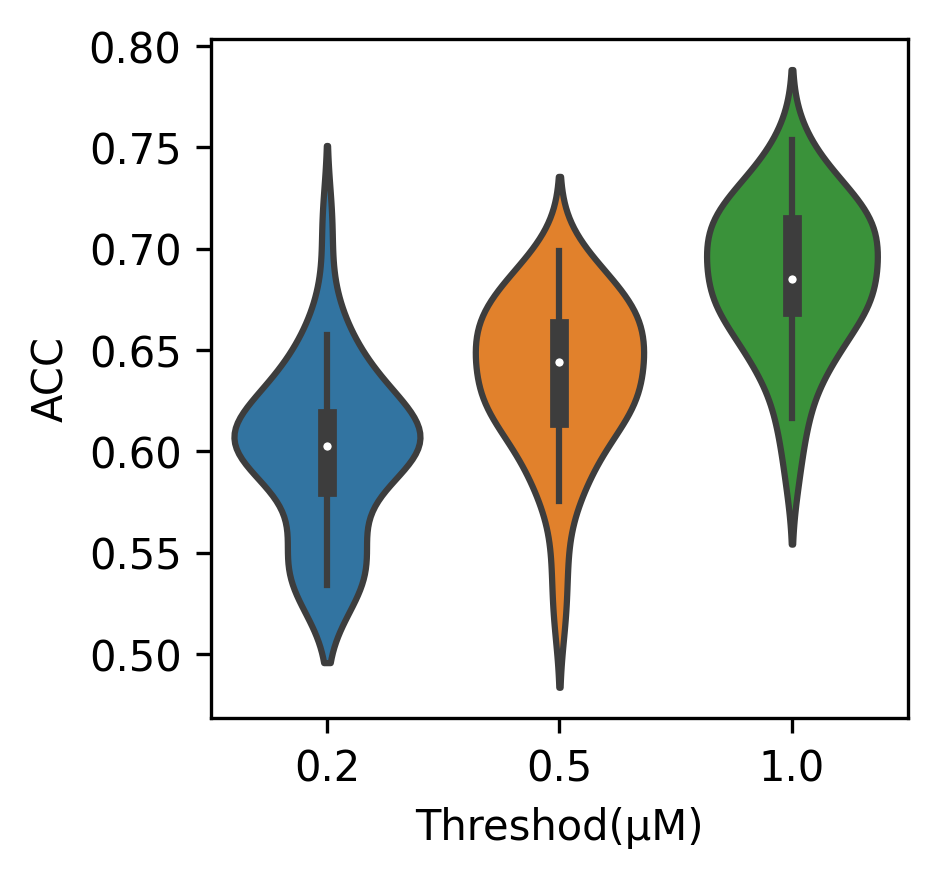

In [397]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)

sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "ACC":ACC_list}), x="Threshod(μM)", y="ACC")


<AxesSubplot:xlabel='Threshod(μM)', ylabel='F1_score'>

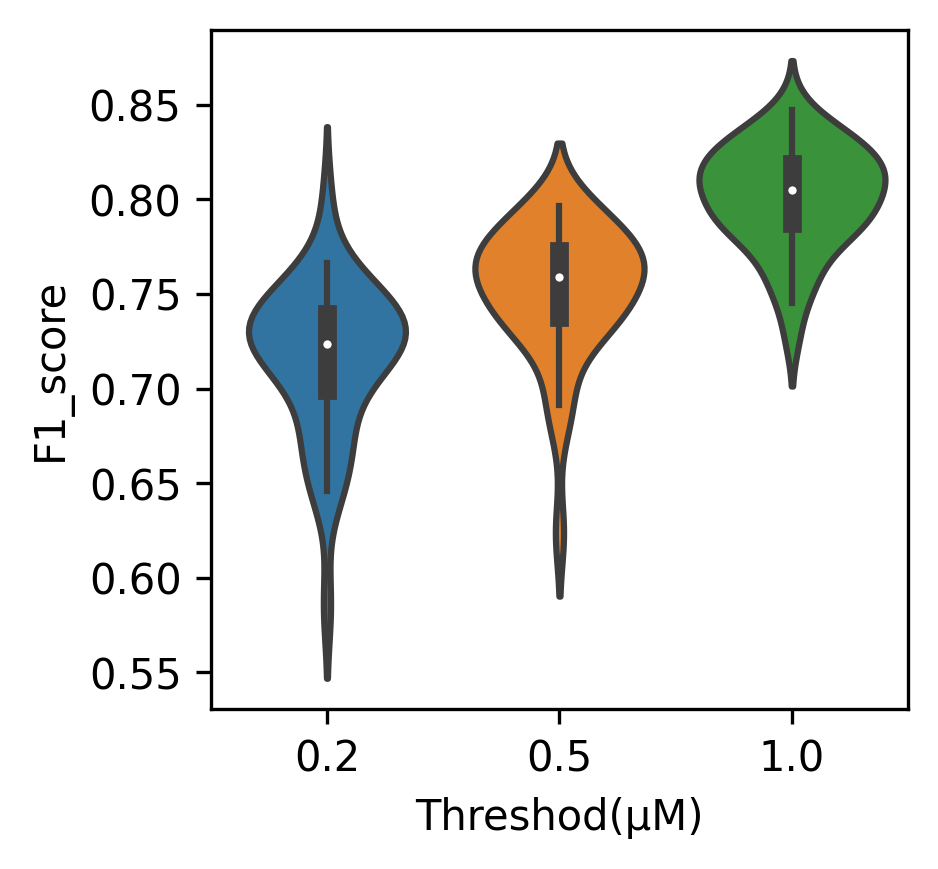

In [398]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)
sns.violinplot(data=pd.DataFrame({"Threshod(μM)":Threshold_list, "F1_score":F1_list}), x="Threshod(μM)", y="F1_score")


In [401]:
# compare prediction models using different feature sets
Threshod = 1
Drug = "Venetoclax"

dic_dataset = {"set1":pd.concat([data_all.iloc[0:,0:22], data_all[Drug]], axis = 1), # Step 1,
               "set2":pd.concat([data_all.iloc[0:,0:50], data_all[Drug]], axis = 1), # Step 2
               "set3":pd.concat([data_all.iloc[0:,0:50+17691], data_all[Drug]], axis = 1) # Step 2

              }
result_with_threshod = {}

for dataset in dic_dataset:
    data_cur = dic_dataset[dataset]
    data_cur = data_cur.dropna()
    new_label = []
    for i in data_cur.iloc[:,-1].values:
        if i <= Threshod:
            new_label.append(1)
        else:
            new_label.append(0)
    data_cur[Drug+"_bi"] = new_label

    result_all = {}
    for random_ in range(0,200,5): 
        sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
        resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]

        train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                            sensitive_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)
        train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                            resistant_data.iloc[:,-1],
                                                                            test_size = 0.2, random_state = random_)

        train_data = pd.concat([train_data_sen, train_data_res])
        test_data = pd.concat([test_data_sen, test_data_res])
        train_labels = pd.concat([train_labels_sen, train_labels_res])
        test_labels = pd.concat([test_labels_sen, test_labels_res])

        result_all[random_] = model_run(train_data,test_data, train_labels, test_labels)
    result_with_threshod[dataset] = result_all


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_18229/3686157383.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur[Drug+"_bi"] = new_label


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_18229/3686157383.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur[Drug+"_bi"] = new_label


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_18229/3686157383.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur[Drug+"_bi"] = new_label


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates

In [405]:
Value_list = []
Type_list = []
Threshold_list = []
ACC_list = []
F1_list = []

for Threshod in  result_with_threshod:
    for random_state in result_with_threshod[Threshod]:
        ACC_list.append(result_with_threshod[Threshod][random_state]['Accuracy'])
        F1_list.append(result_with_threshod[Threshod][random_state]['F1_score'])
        Threshold_list.append(Threshod)



<AxesSubplot:xlabel='FeatureSet', ylabel='F1_score'>

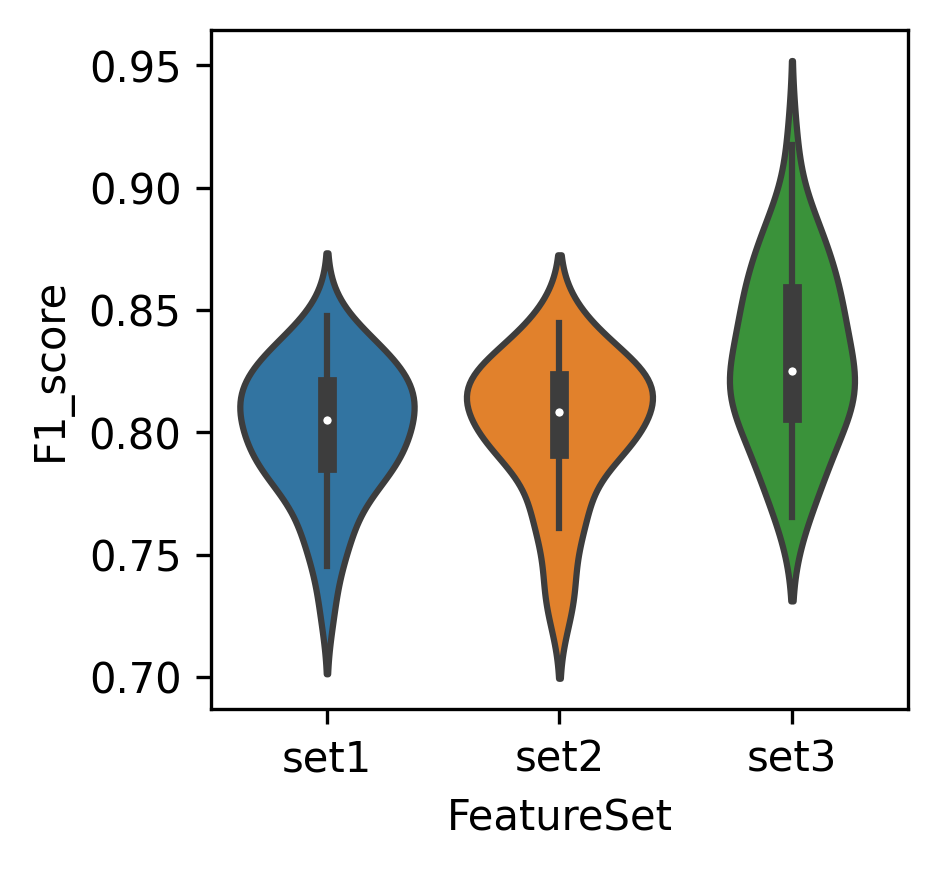

In [406]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)
sns.violinplot(data=pd.DataFrame({"FeatureSet":Threshold_list, "F1_score":F1_list}), x="FeatureSet", y="F1_score")


<AxesSubplot:xlabel='FeatureSet', ylabel='Accuracy'>

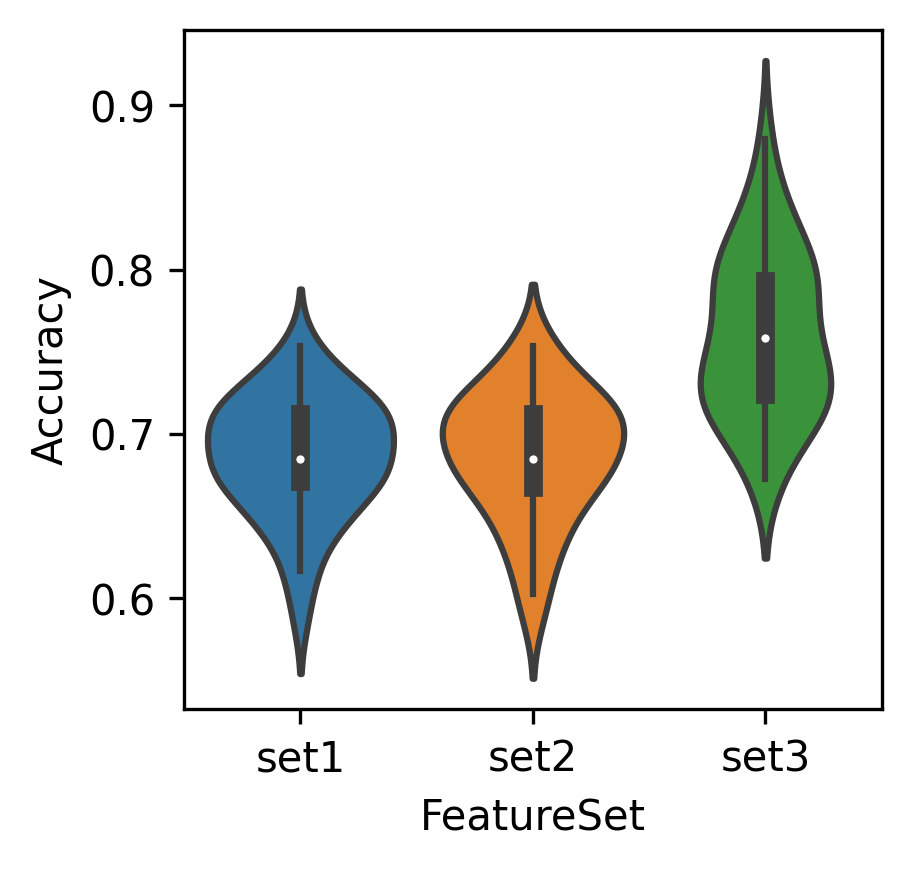

In [404]:
import seaborn as sns
plt.figure(figsize = (3,3),dpi = 300)
sns.violinplot(data=pd.DataFrame({"FeatureSet":Threshold_list, "Accuracy":ACC_list}), x="FeatureSet", y="Accuracy")


In [410]:
result_with_threshod

{'set1': {0: {'random_state': 0,
   'best_params': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
   'Accuracy': 0.726027397260274,
   'Precision': 0.7205882352941176,
   'sensitivity': 0.98,
   'F1_score': 0.8305084745762712,
   'features':    Feature       IMP
   11    KRAS  0.116375
   20    NRAS  0.093045
   14    TP53  0.087631
   19   SRSF2  0.084416
   3     EZH2  0.081814
   12    IDH1  0.076799
   0     TET2  0.073635
   8      WT1  0.064605
   18  PTPN11  0.050219
   17   U2AF1  0.049490
   9    CEBPA  0.045030
   16  DNMT3A  0.041067
   10    NPM1  0.038801
   2    RUNX1  0.031799
   6    SF3B1  0.021203
   7    GATA2  0.014102
   15   ASXL1  0.012687
   5     FLT3  0.009038
   1    STAG2  0.008242},
  5: {'random_state': 5,
   'best_params': {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100},
   'Accuracy': 0.7123287671232876,
   'Precision': 0.7301587301587301,
   'sensitivity': 0.92,
   'F1_score': 0.8141592920353983,
   'features':    Feature    

In [416]:
feature_IMP =pd.DataFrame()
for random_state in result_with_threshod['set3']:
    features = result_with_threshod['set3'][random_state]['features']['Feature'].values
    IMP = result_with_threshod['set3'][random_state]['features']['IMP'].values
    cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
    cur_df.index = features
    feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
    
IMP_sum = feature_IMP.transpose().sum()
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(80)

([<matplotlib.axis.XTick at 0x14c9bc0d0>,
 [Text(0, 0, 'R_CDA'),
  Text(1, 0, 'R_EVI2B'),
  Text(2, 0, 'R_RP11-355O1.7'),
  Text(3, 0, 'R_MAFB'),
  Text(4, 0, 'R_RP11-51O6.1'),
  Text(5, 0, 'R_RPS15P5'),
  Text(6, 0, 'R_RP11-747H12.4'),
  Text(7, 0, 'R_RP11-526K21.2'),
  Text(8, 0, 'R_ANAPC7'),
  Text(9, 0, 'R_RP11-543B16.1'),
  Text(10, 0, 'R_SNORD4A'),
  Text(11, 0, 'R_CHMP4A'),
  Text(12, 0, 'R_HMGN2P6'),
  Text(13, 0, 'R_PRKCI'),
  Text(14, 0, 'R_P2RY13'),
  Text(15, 0, 'R_RPL5P9'),
  Text(16, 0, 'R_SLC15A3'),
  Text(17, 0, 'R_FGD4'),
  Text(18, 0, 'R_CUTC'),
  Text(19, 0, 'R_CTD-2248H3.1'),
  Text(20, 0, 'R_CTC-510F12.4'),
  Text(21, 0, 'R_RPS27AP1'),
  Text(22, 0, 'R_AC021016.7'),
  Text(23, 0, 'R_LILRA6'),
  Text(24, 0, 'R_CTAGE1'),
  Text(25, 0, 'R_RP11-572P18.1'),
  Text(26, 0, 'R_RP11-267J23.4'),
  Text(27, 0, 'R_DYNLL1P1'),
  Text(28, 0, 'R_STAP1'),
  Text(29, 0, 'R_YBX1P6'),
  Text(30, 0, 'R_HNRNPA3P10'),
  Text(31, 0, 'R_PECR'),
  Text(32, 0, 'R_SETP20'),
  Text(33, 0, 'R_

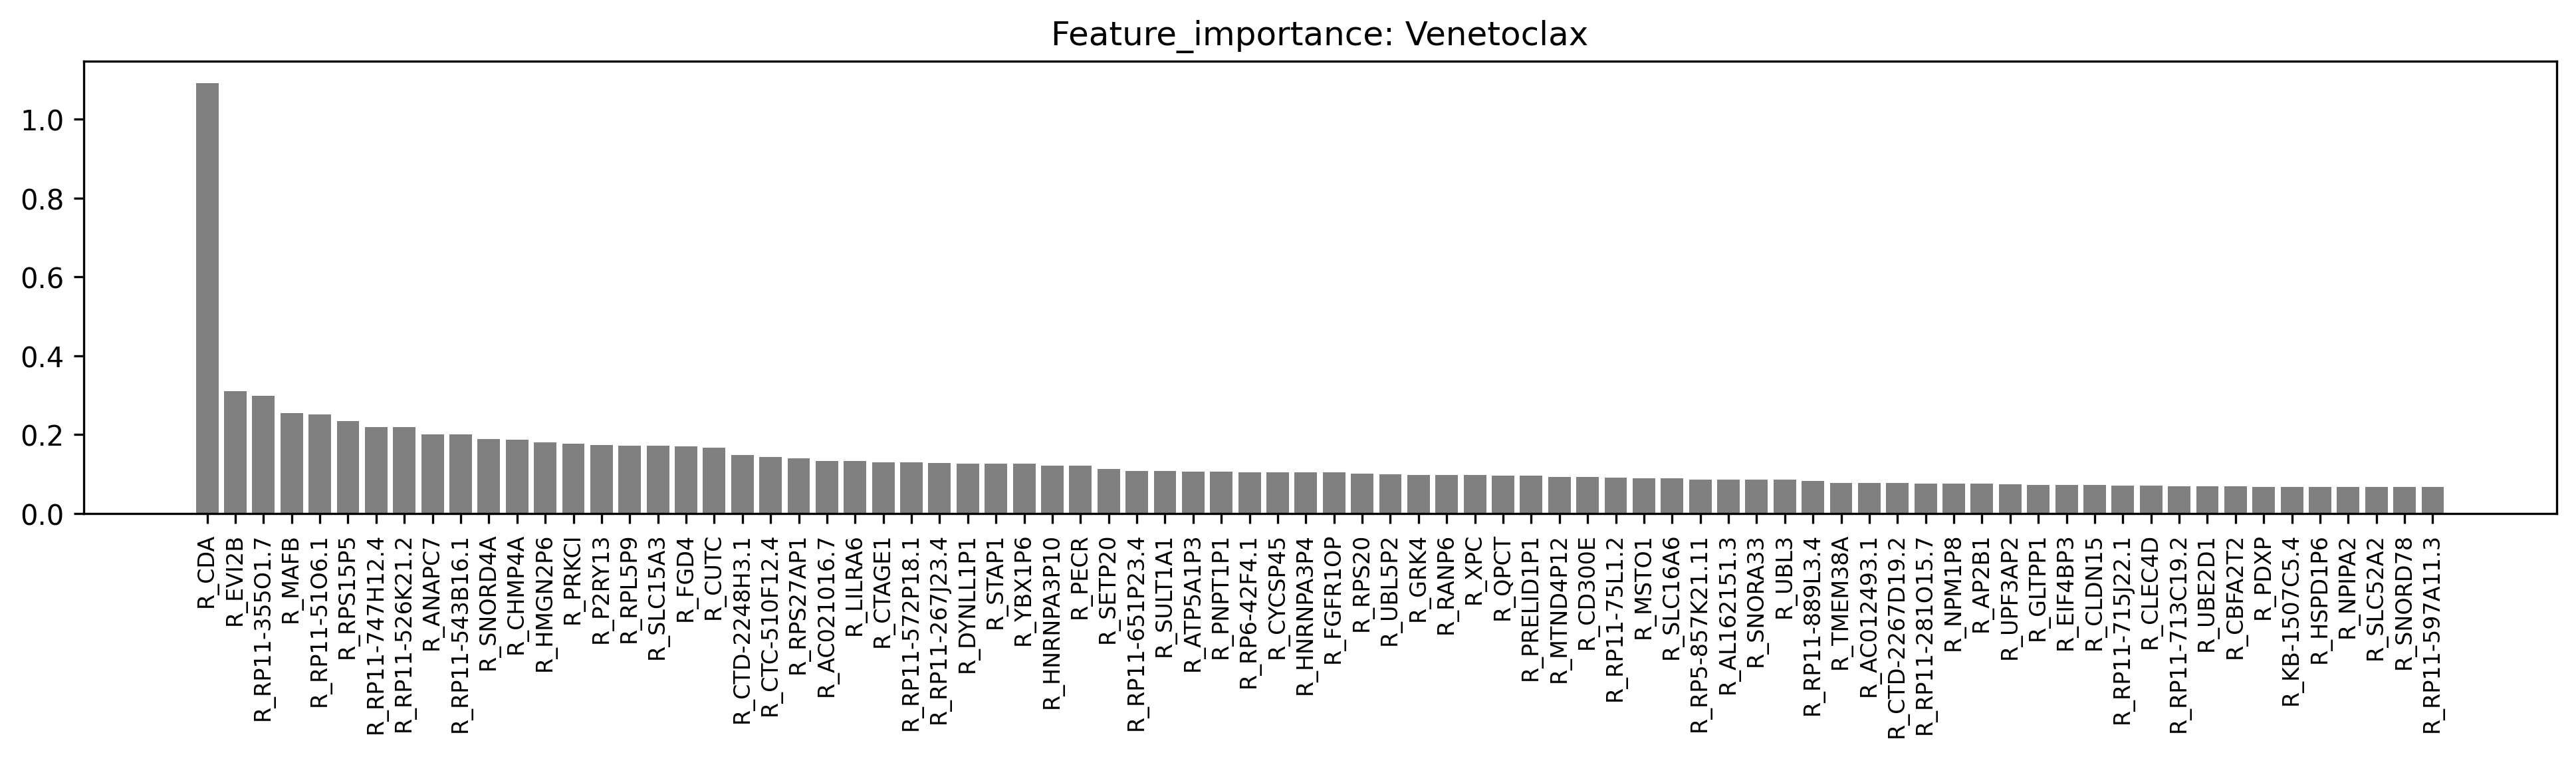

In [448]:
plt.figure(figsize = (16,3),dpi = 300)
plt.title("Feature_importance: " + "Venetoclax")
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),x_feature_sorted['Feature'] , rotation = 90, fontsize =8)


In [449]:

x_feature.sort_values(by = ["IMP"], ascending = False).to_csv("Feature_importance_summary_Feb14_2023.csv")


In [169]:
x_feature.loc[x_feature['Feature'] == 'R_BCL2']

,Feature,IMP
1248,R_BCL2,0.006254


In [157]:
feature_df.to_csv("Feature_importance_venetoclax_model3_mut_vaf_rnaseq_gt1_50p_Feb14_2023.csv")



/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


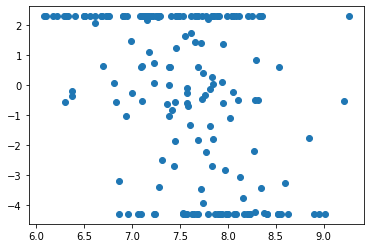

In [265]:

plt.scatter(data_all['R_RPL5P9'], np.log(data_all[Drug]))


Text(0.5, 1.0, 'Venetoclax')

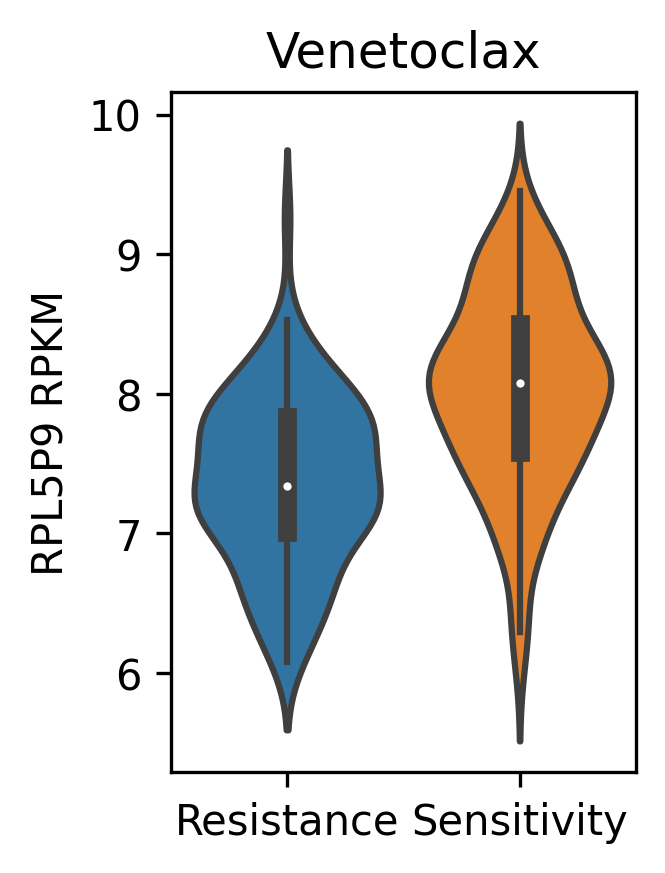

In [432]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 300)
Drug = "Venetoclax"
feature_sele = 'R_EVI2B'
feature_sele = 'R_RPL5P9'
#feature_sele = 'R_CDA'

sns.violinplot(data=data_cur,  x=Drug+"_bi", y=feature_sele)
plt.ylabel(feature_sele.split("_")[1] + " RPKM")
plt.xticks(ticks = [0,1], labels = ["Resistance","Sensitivity"])
plt.xlabel('')
plt.title("Venetoclax")

In [433]:
from scipy.stats import ranksums

ranksums( data_cur.loc[data_cur[Drug+"_bi"] == 1][feature_sele].values, data_cur.loc[data_cur[Drug+"_bi"] == 0][feature_sele].values)

RanksumsResult(statistic=7.423905098713767, pvalue=1.1371665355436983e-13)

In [434]:
data_all
from scipy import stats
pos_cor = []
neg_cor = []
P_list = []
cor_list = []
Drug_list = []
for Drug in data_all.columns[17691+50:]:
    x = data_all.loc[:, [feature_sele,Drug]]
    x = x.dropna()
    Drug_list.append(Drug)
    r,p = stats.spearmanr(x[feature_sele], np.log(x[Drug]))
    P_list.append(p)
    cor_list.append(r)

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

FDR_list = multitest.multipletests(P_list, alpha=0.05, method='fdr_bh')[1]   

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, 

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, 

In [435]:
y = pd.DataFrame({"Drug":Drug_list, "r":cor_list, 'P':P_list, "FDR":FDR_list})


In [436]:
y.loc[y['FDR']<0.05].sort_values(by = ['r']).shape[0]


51

In [437]:
feature_sele

'R_RPL5P9'

([<matplotlib.axis.XTick at 0x151345420>,
 [Text(0, 0, 'Venetoclax'),
  Text(1, 0, 'Nutlin 3a'),
  Text(2, 0, 'Bay 11-7085'),
  Text(3, 0, 'Lenvatinib'),
  Text(4, 0, 'Vemurafenib (PLX-4032)'),
  Text(5, 0, 'JQ1'),
  Text(6, 0, 'Volasertib (BI-6727)'),
  Text(7, 0, 'DBZ'),
  Text(8, 0, 'Palbociclib'),
  Text(9, 0, 'Entospletinib (GS-9973)'),
  Text(10, 0, 'Panobinostat'),
  Text(11, 0, 'Gilteritinib (ASP-2215)'),
  Text(12, 0, 'SR9011'),
  Text(13, 0, 'Lenalidomide'),
  Text(14, 0, 'Lovastatin'),
  Text(15, 0, 'Selinexor'),
  Text(16, 0, 'NF-kB Activation Inhibitor'),
  Text(17, 0, 'Entrectinib'),
  Text(18, 0, 'Ibrutinib (PCI-32765)'),
  Text(19, 0, 'LY-333531'),
  Text(20, 0, 'Erlotinib'),
  Text(21, 0, 'INK-128'),
  Text(22, 0, 'VX-745'),
  Text(23, 0, 'Linifanib (ABT-869)'),
  Text(24, 0, 'ABT-737'),
  Text(25, 0, 'AT7519'),
  Text(26, 0, 'CI-1040 (PD184352)'),
  Text(27, 0, 'JNJ-7706621'),
  Text(28, 0, 'Bortezomib (Velcade)'),
  Text(29, 0, 'PI-103'),
  Text(30, 0, '17-AAG (Tanes

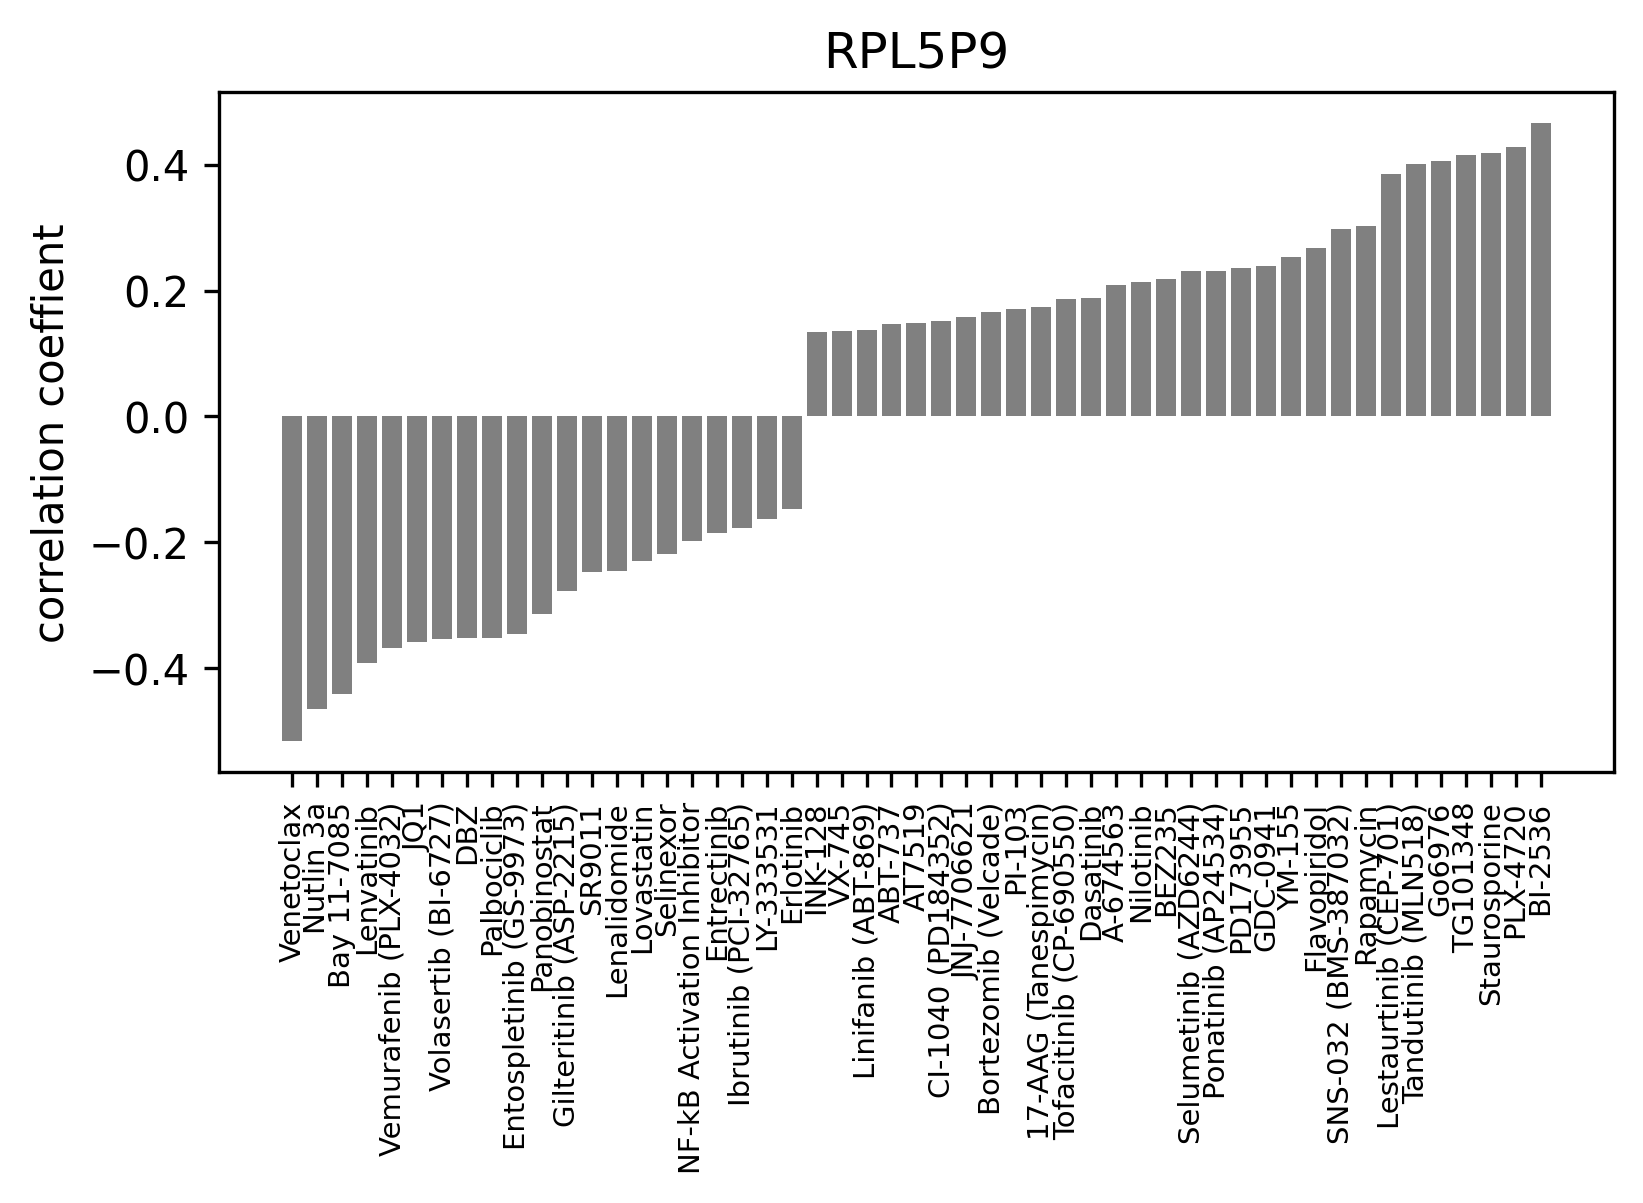

In [439]:
y.loc[y['FDR']<0.05].sort_values(by = ['r'])
plt.figure(figsize = (6,3),dpi = 300)
plt.title(feature_sele.split("_")[1])
plt.bar(np.arange(0, y.loc[y['FDR']<0.05].sort_values(by = ['r']).shape[0], 1), y.loc[y['FDR']<0.05].sort_values(by = ['r'])['r'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
plt.ylabel("correlation coeffient")
plt.xticks(np.arange(0, y.loc[y['FDR']<0.05].sort_values(by = ['r']).shape[0], 1), y.loc[y['FDR']<0.05].sort_values(by = ['r'])['Drug'], rotation = 90, fontsize =7)


In [292]:
list(y.loc[y['FDR']<0.05].sort_values(by = ['r'], ascending = False)['Drug'])

['Venetoclax',
 'Palbociclib',
 'PHA-665752',
 'Erlotinib',
 'Nutlin 3a',
 'GSK-1838705A',
 'LY-333531',
 'NF-kB Activation Inhibitor',
 'Panobinostat',
 'Neratinib (HKI-272)',
 'MLN8054',
 'Bay 11-7085',
 '17-AAG (Tanespimycin)',
 'SNS-032 (BMS-387032)',
 'Linifanib (ABT-869)',
 'MK-2206',
 'BEZ235',
 'Selumetinib (AZD6244)',
 'Axitinib (AG-013736)',
 'GDC-0941',
 'Dasatinib',
 'Nilotinib',
 'Rapamycin']

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

Text(0, 0.5, 'Density')

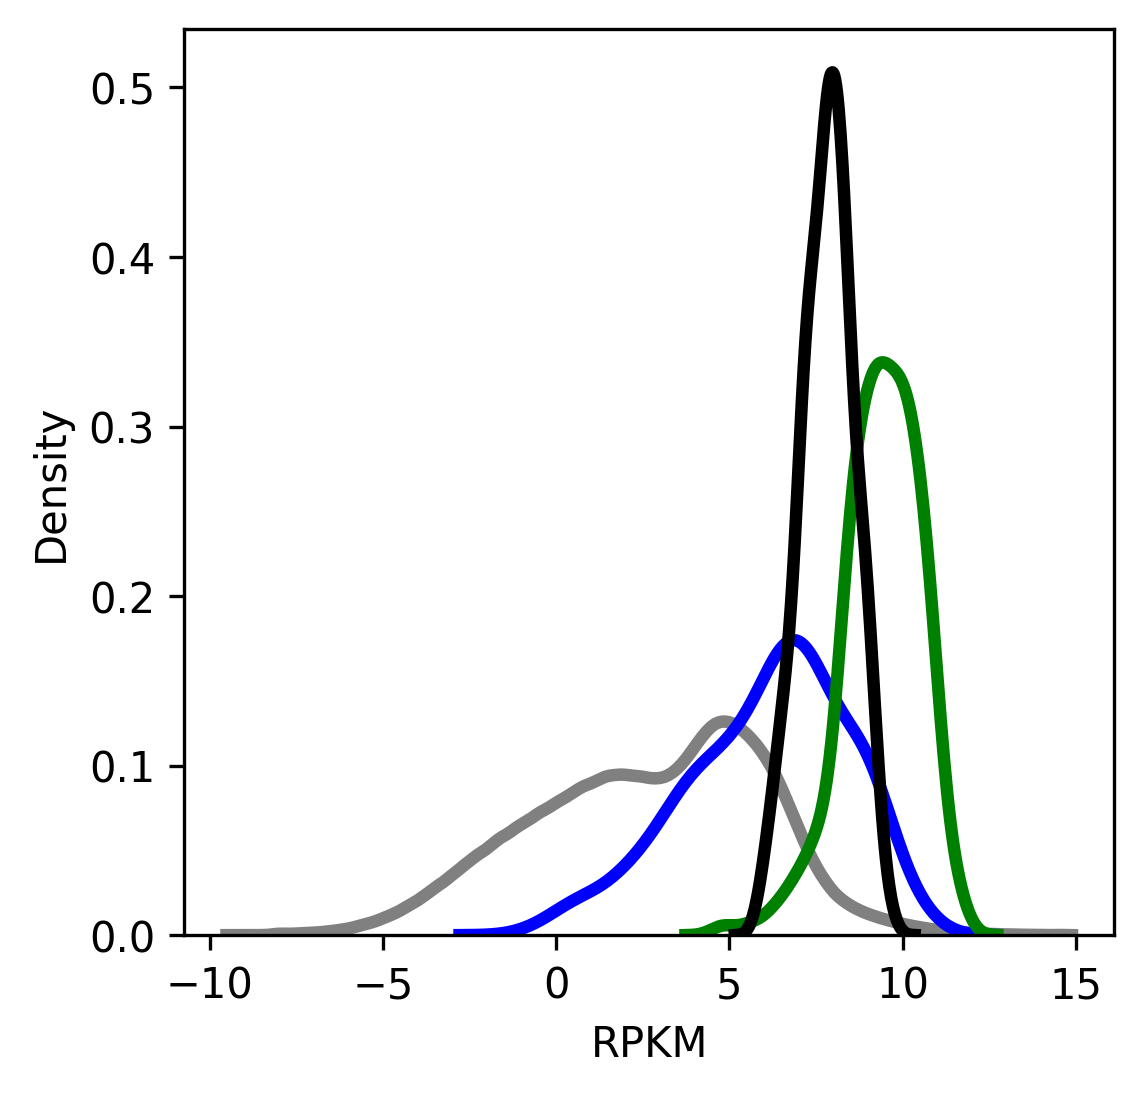

In [314]:
plt.figure(figsize = (4,4),dpi = 300)

sns.distplot(data_all.iloc[0:783,51:50+22843], hist = False, kde = True,
                 kde_kws = {'linewidth': 3}, label = "all_genes", color = 'grey')
sns.distplot(data_all['R_CDA'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3}, label = "CDA", color = "blue")
sns.distplot(data_all['R_EVI2B'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3}, label = "RPL5P9", color = "green")
sns.distplot(data_all['R_RPL5P9'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3}, label = "RPL5P9", color = "black")

plt.xlabel('RPKM')
plt.ylabel('Density')

Text(0, 0.5, 'CDA (RPKM)')

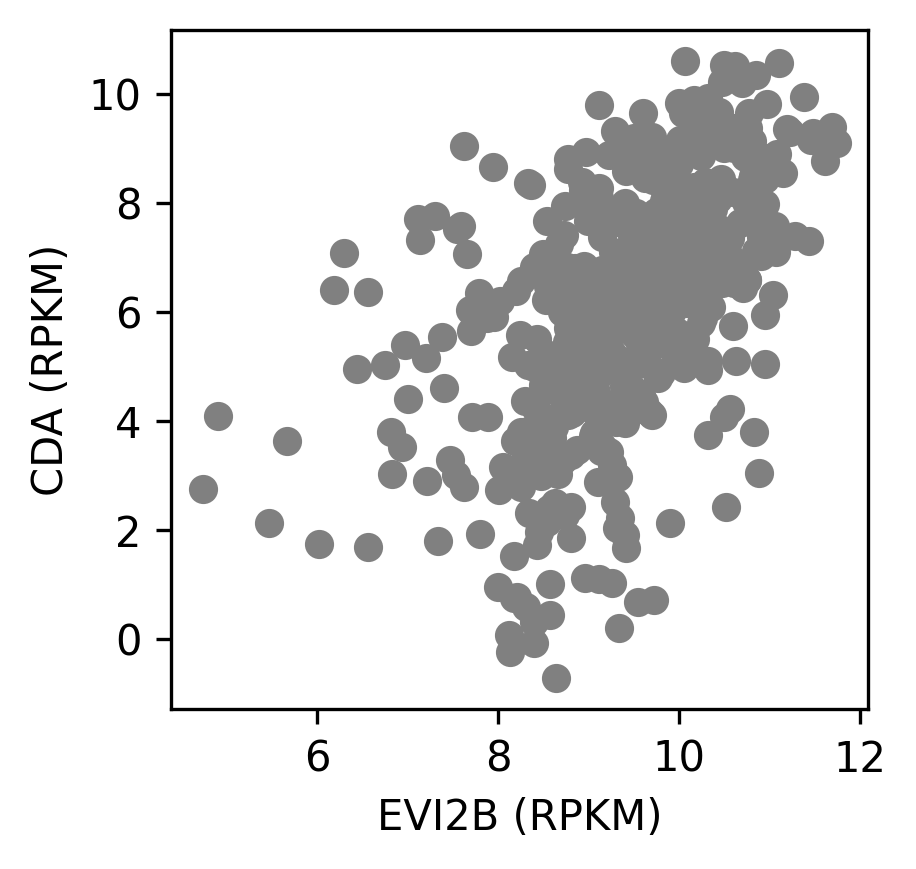

In [343]:
plt.figure(figsize = (3,3),dpi = 300)

x = data_all.loc[:,['R_EVI2B','R_CDA']]
x = x.dropna()
plt.scatter(data_all['R_EVI2B'],data_all['R_CDA'], color = 'gray' )
plt.xlabel("EVI2B (RPKM)")
plt.ylabel("CDA (RPKM)")

In [454]:
print("featureSet,random_state,Accuracy,Precision,sensitivity,F1_score")
for dataset in result_with_threshod:
    result_all = result_with_threshod[dataset]
    for randome_ in result_all:
        print(dataset + ',' + str(result_all[randome_]['random_state'])+"," + str(result_all[randome_]['Accuracy']) + "," +
              dataset + ',' + str(result_all[randome_]['Precision']) + "," + str(result_all[randome_]['sensitivity']) + "," + str(result_all[randome_]['F1_score']))
        


featureSet,random_state,Accuracy,Precision,sensitivity,F1_score
set1,0,0.726027397260274,set1,0.7205882352941176,0.98,0.8305084745762712
set1,5,0.7123287671232876,set1,0.7301587301587301,0.92,0.8141592920353983
set1,10,0.726027397260274,set1,0.7272727272727273,0.96,0.8275862068965517
set1,15,0.6712328767123288,set1,0.7166666666666667,0.86,0.7818181818181817
set1,20,0.6438356164383562,set1,0.6875,0.88,0.7719298245614036
set1,25,0.6164383561643836,set1,0.671875,0.86,0.7543859649122807
set1,30,0.6438356164383562,set1,0.7068965517241379,0.82,0.7592592592592593
set1,35,0.684931506849315,set1,0.7014925373134329,0.94,0.8034188034188033
set1,40,0.6164383561643836,set1,0.6833333333333333,0.82,0.7454545454545455
set1,45,0.726027397260274,set1,0.7142857142857143,1.0,0.8333333333333333
set1,50,0.7123287671232876,set1,0.704225352112676,1.0,0.8264462809917354
set1,55,0.7123287671232876,set1,0.7101449275362319,0.98,0.823529411764706
set1,60,0.6438356164383562,set1,0.6764705882352942,0.92,0.7796610169

In [456]:
for dataset in result_with_threshod:
    result_all = result_with_threshod[dataset]

    for randome_ in result_all:
        print(dataset + "," + str(randome_))
        print( result_all[randome_]['best_params'])

set1,0
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
set1,5
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,10
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,15
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,20
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,25
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
set1,30
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
set1,35
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,40
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
set1,45
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,50
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,55
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,60
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
set1,65
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
set1,70
{'learning_rate': 0.05, 'max_d

## result_all has been output to model_3_mut_vaf_rnaseq_acc.csv